# Setup

In [1]:
import os
os.environ["CALITP_BQ_MAX_BYTES"] = str(800_000_000_000)

import pandas as pd
import numpy as np
import warnings

from io import StringIO
from calitp.tables import tbl
from calitp import query_sql
from datetime import date, datetime
from siuba import *
from siuba.dply.forcats import fct_rev
from plotnine import *

def friendly_date(x): 
    return datetime.strptime(x, "%Y-%m-%d").strftime("%b %d")

import datetime as dt

In [2]:
DIR_PATH="2022/05/208"

#CALITP_ITP_ID = 10
#CALITP_ITP_ID=45
#CALITP_ITP_ID=269
#CALITP_ITP_ID=108
#CALITP_ITP_ID=106
CALITP_ITP_ID=208
CALITP_URL_NUMBER = 0
DEBUG = False

DATE_START = "2022-05-01"
DATE_END = "2022-05-31"
PUBLISH_DATE = "2022-06-01"

CHANGE_PLOT_BREAKS = ["Added", "Removed", "Unchanged"]
CHANGE_PLOT_VALUES = ["#51BF9D","#E16B26", "#8CBCCB"]

In [3]:
DATE_TODAY=date.today()
START_MONTH_DAY = friendly_date(DATE_START)
END_MONTH_DAY = friendly_date(DATE_END)

WEEK_MARKERS = pd.date_range(DATE_START, DATE_END, freq="W").astype(str).tolist()
BIWEEKLY_DT = pd.date_range(DATE_START, DATE_END, freq="2W")
BIWEEKLY_MARKERS = BIWEEKLY_DT.astype(str).tolist()

In [4]:
if not DEBUG:
    warnings.filterwarnings("ignore")

In [5]:
# Convenience functions ----

filter_start = filter(
    _.calitp_extracted_at <= DATE_START,
    _.calitp_deleted_at.fillna("2099-01-01") > DATE_START,
)

filter_end = filter(
    _.calitp_extracted_at <= DATE_END,
    _.calitp_deleted_at.fillna("2099-01-01") > DATE_END,
)

filter_itp = filter(
    _.calitp_itp_id == CALITP_ITP_ID, _.calitp_url_number == CALITP_URL_NUMBER
)

def collect_to_dict(df):
    """Return the first row of a DataFrame as a dictionary.
    
    If there are no rows, then all dictionary values are None.
    """
    
    result = collect(df)
    
    if len(result) == 0:
        return {k: None for k in result.columns}
    # elif len(result) > 1:
    #     raise ValueError("table contained more than 1 row")
    else:
        return result.iloc[0,:].to_dict()


select_rm_calitp = select(
    -_.calitp_itp_id,
    -_.calitp_url_number,
    -_.calitp_hash,
    -_.calitp_extracted_at,
    -_.calitp_deleted_at,
)

def percent_format(labels):
    return ["{:.0f}%".format(v*100) for v in labels]

def query_id_changes(start_table, end_table, id_vars):
    """Calculate id variables that are removed, added, or unchanged between tables.
    
    It works by adding a special column to each table, performing a full join,
    then checking where the special column is null.
    """
    sym_id_vars = [_[k] for k in id_vars]

    is_in_start = start_table >> select(*id_vars) >> mutate(is_in_start=True)
    is_in_end = end_table >> select(*id_vars) >> mutate(is_in_end=True)

    baseline = start_table >> count(*id_vars) >> rename(n_baseline="n")
    tallies = (
        is_in_start
        >> full_join(_, is_in_end, id_vars)
        >> count(*sym_id_vars, _.is_in_start, _.is_in_end)
        >> mutate(
            status=case_when(
                _,
                {
                    _.is_in_end.isna(): "Removed",
                    _.is_in_start.isna(): "Added",
                    True: "Unchanged",
                },
            )
        )
        >> count(*sym_id_vars[:-1], _.status)
        >> group_by(*sym_id_vars[:-1])
        >> mutate(percent=_.n / _.n.sum())
    )

    return tallies

In [6]:
# Data ====
# 1. High level feed info ----

## start/end dates now dt.date, need to format downstream?...
## collect here for 1 less query, small table after all
tbl_dim_feeds = (tbl.views.gtfs_schedule_dim_feeds()
     >> filter_end
     >> filter_itp
     >> collect()
    )

status = (
    tbl_dim_feeds   
    >> select(_.calitp_agency_name, _.raw_gtfs_schedule_url)
    >> pipe(collect_to_dict)
    )

feed_info = (tbl_dim_feeds
    >> select(_.feed_publisher_name, _.feed_publisher_url, _.feed_lang,
           _.default_lang, _.feed_start_date, _.feed_end_date, _.feed_version,
           _.feed_contact_email, _.feed_contact_url)
    >> pipe(collect_to_dict)
    )

if feed_info['feed_start_date']:
    feed_info['feed_start_date'] = feed_info['feed_start_date'].strftime('%Y%m%d')
if feed_info['feed_end_date']:
    feed_info['feed_end_date'] = feed_info['feed_end_date'].strftime('%Y%m%d')

In [7]:
feed_info['has_feed_info'] = any(feed_info.values())

False

In [8]:
## new table!
tbl_daily_service = query_sql(f"""
SELECT *
FROM `cal-itp-data-infra.views.reports_daily_service_routes_stops`
WHERE calitp_itp_id = {CALITP_ITP_ID} AND calitp_url_number = {CALITP_URL_NUMBER}
AND service_date BETWEEN '{DATE_START}' AND '{DATE_END}'
""")
tbl_daily_service['ttl_service_hours'] = tbl_daily_service.ttl_service_hours.fillna(0)
tbl_daily_service = tbl_daily_service >> arrange(_.service_date)
tbl_daily_service = tbl_daily_service >> mutate(weekday = _.service_date.apply(lambda x: x.weekday()))

E0628 00:06:22.755601550    1418 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies


In [9]:
# 1.5. Route and Stop info
## specific date makes more sense (end of month, maintain consistency)
end_date_routes_stops = (tbl_daily_service
                         >> filter(_.service_date == BIWEEKLY_DT[-1])
                         >> select(_.n_routes, _.n_stops)
                        )

feed_info["n_routes"] = int(end_date_routes_stops.iloc[0, 0])
feed_info["n_stops"] = int(end_date_routes_stops.iloc[0, 1])

In [10]:
# 2. Monthly metrics ----
# Service hours per day

# number of days where a feed did not have any trips in service
n_days_no_service = (
    tbl_daily_service
    >> filter(_.ttl_service_hours == 0.0)
    >> pipe(lambda d: {"n": d.shape[0]})
)

# 3. Stop and Route ID Changes ----

query_id_changes = (
    filter(_.metric_period == "month")
    >> filter_itp 
    # note that metric dates for calendar type roll-ups (e.g. month, quarter) is the first day of the next
    # period (e.g. metric date June 1st rolls up May).
    >> filter(_.metric_date == PUBLISH_DATE)
    >> rename(status = "change_status")
    >> mutate(percent = _.n / _.n.sum())
    >> collect()
)

tbl_stops_changed = tbl.views.gtfs_schedule_fact_stop_id_changes() >> query_id_changes
tbl_routes_changed = tbl.views.gtfs_schedule_fact_route_id_changes() >> query_id_changes

In [11]:
# 4. Feed files being checked for ----

file_categories = pd.DataFrame(
    {
        "shapes.txt": "Visual display",
        "pathways.txt": "Navigation",
        "levels.txt": "Navigation",
        "fare_rules.txt": "Fares",
        "fare_leg_rules.txt": "Fares",
        "feed_info.txt": "Technical contacts",
    }.items(),
    columns=["name", "category"],
)

importance = ["Visual display", "Navigation", "Fares", "Technical contacts"]

tbl_file_check = (
    tbl.gtfs_schedule_history.calitp_files_updates()
    >> filter_itp
    >> filter(_.calitp_extracted_at.isin(BIWEEKLY_MARKERS))
    >> select(_.name, _.calitp_extracted_at)
    >> collect()
    >> right_join(_, file_categories, ["name"])
    >> mutate(
        calitp_extracted_at=_.calitp_extracted_at.fillna("missing").astype(str),
        success="✅",
    )
    >> spread(_.calitp_extracted_at, _.success)
    >> select(-_.missing)
    >> arrange(_.category.apply(importance.index))
    >> select(_.category, _.contains(""))
    >> pipe(_.fillna(""))
)

# Analyze validation notices ----

from sqlalchemy.sql import func

tbl_biweekly = (
    tbl.views.dim_date()
    >> filter(_.full_date.isin(BIWEEKLY_MARKERS))
    >> select(_.date == _.full_date)
)

tbl_validation_notices_raw = (
    tbl.gtfs_schedule_type2.validation_notices()
    >> filter_itp
    >> inner_join(
        _,
        tbl_biweekly,
        sql_on = (lambda lhs, rhs:
                  (lhs.calitp_extracted_at <= rhs.date) &
                  (func.coalesce(lhs.calitp_deleted_at, "2099-01-01") > rhs.date)
        )
    )
    # do a simple count of the number of notices on each date
    >> select(_.date, _.code, _.severity)
    >> count(_.date, _.code, _.severity)
    >> collect()
)

In [12]:
# create a DataFrame with correct columns and no rows
_validation_empty = pd.DataFrame(
    dict([("code", []), ("severity", []), *zip(BIWEEKLY_MARKERS, [tuple()] * len(BIWEEKLY_MARKERS))]),
)

# spread validation notices so dates are columns, and counts are values
# TODO: when we spread the dates out, the counts sometimes can become floats,
# so have decimals, which might look funky. We can fix this by either converting
# the counts to strings before the code below
if not tbl_validation_notices_raw.shape[0]:
    _tbl_validation_notices = _validation_empty
else:
    out_wide = (
        tbl_validation_notices_raw >> mutate(date=_.date.astype(str)) >> spread(_.date, _.n)
    )
    
    _tbl_validation_notices = pd.concat(
        [_validation_empty, out_wide], ignore_index=True
    ).fillna("")

In [13]:
# create a DataFrame with correct columns and no rows
_validation_severity_empty = pd.DataFrame(
    dict([("code", []), ("severity", []), *zip(BIWEEKLY_MARKERS, [tuple()] * len(BIWEEKLY_MARKERS))]),
)

# spread validation notices so dates are columns, and counts are values
# TODO: when we spread the dates out, the counts sometimes can become floats,
# so have decimals, which might look funky. We can fix this by either converting
# the counts to strings before the code below
if not tbl_validation_notices_raw.shape[0]:
    _tbl_validation_severity = _validation_severity_empty
else:
    out_wide = (
        tbl_validation_notices_raw >> mutate(date=_.date.astype(str)) >> spread(_.date, _.n)
    )
    
    _tbl_validation_severity = pd.concat(
        [_validation_severity_empty, out_wide], ignore_index=True
    ).fillna("")

In [14]:
tbl_code_descriptions = (
    tbl.views.validation_code_descriptions()
    >> select(_.code, _.human_readable_description)
    >> collect()
    # convert code to snakecase,
    # note that this currently screws up cases like IO -> i_o
    >> mutate(code = _.code.str.replace(r'(?<!^)(?=[A-Z])', '_').str.lower().str.replace("_notice$", ""))
)

tbl_validation_notices_unfiltered = (
    _tbl_validation_notices 
    >> inner_join(_, tbl_code_descriptions, ["code"])
    >> select(_.code, _.human_readable_description, _.contains(""))
    #>> rename(error_name = _.code, error_description=_.human_readable_description)
)

tbl_validation_severity = (
    _tbl_validation_severity
    >> inner_join(_, tbl_code_descriptions, ["code"])
    >> select(_.code, _.human_readable_description, _.severity)
)

# hackily remove float decimal values by casting to string and removing ".0"
# see https://stackoverflow.com/a/68693516/269834
for col in tbl_validation_notices_unfiltered.columns[2:]:
    tbl_validation_notices_unfiltered[col] = tbl_validation_notices_unfiltered[col].astype(str).apply(lambda x: x.replace('.0',''))

In [15]:
#filter tbl_validation for severity

tbl_validation_notices = (
    tbl_validation_notices_unfiltered
    >> select(-_.severity)
)

## Dump data

In [16]:
# Note that everything is saved in this cell, except for plots,
# which are saved in the cell they're defined in

import json
import shutil

from pathlib import Path

def to_rowspan_table(df, span_col):
    d = df.to_dict(orient="split")
    row_span = df.groupby(span_col)[span_col].transform("count")
    not_first = df[span_col].duplicated()
    
    row_span[not_first] = 0
    
    d["rowspan"] = row_span.tolist()
    return d


out_dir = Path(f"outputs/{DIR_PATH}/data")
out_dir.mkdir(parents=True, exist_ok=True)


json.dump(feed_info, open(out_dir / "1_feed_info.json", "w"))
json.dump(status, open(out_dir / "1_status.json", "w"))

tbl_daily_service.to_json(
    out_dir / "2_daily_service_hours.json", orient="records"
)
json.dump(n_days_no_service, open(out_dir / "2_n_days_no_service.json", "w"))

tbl_stops_changed.to_json(out_dir / "3_stops_changed.json", orient="records")
tbl_routes_changed.to_json(out_dir / "3_routes_changed.json", orient="records")

json.dump(to_rowspan_table(tbl_file_check, "category"), open(out_dir / "4_file_check.json", "w"))
tbl_validation_severity.to_json(out_dir / "4_validation_severity.json", orient="split")
tbl_validation_notices.to_json(out_dir / "5_validation_notices.json", orient="split")

In [17]:
## Service Hours Plot

p = (
#     tbl_daily_service_hours
    tbl_daily_service
    >> ggplot(aes("service_date", "ttl_service_hours", group = 1))
    + geom_line()
    + geom_point()
    + theme_minimal(base_size=16)    
    + theme(axis_text_x=element_text(angle=45, hjust=1))
    + scale_x_datetime(date_breaks="1 week")
    + expand_limits(y=0)
    + labs(
        y = "Total service hours",
        x = "Service date",
        #title="Service hours per day"
    )
)

p.save(out_dir / "2_service_hours.png", width=4, height=4, dpi=300)
#p.save(out_dir / "2_service_hours.png")

In [32]:
def plot_service_hours(df, weekday_range):
    
    df = df >> filter(_.weekday.isin(weekday_range))
    
    p = (
#     tbl_daily_service_hours
    df
    >> ggplot(aes("service_date", "ttl_service_hours", group = 1))
    + geom_line()
    + geom_point()
#     + geom_text((aes(label='service_date')))
    + theme_minimal(base_size=16)    
    + theme(axis_text_x=element_text(angle=45, hjust=1))
    + scale_x_datetime(date_breaks="3 days")
    + expand_limits(y=0)
#     + expand_limits(y=df.ttl_service_hours.min() - 200)
    + theme(figure_size = (4, 3))
    + labs(
        y = "Total service hours",
        x = "Service date",
        #title="Service hours per day"
        )
    )
    p.draw();
    return p

In [33]:
weekday_ranges = list(zip([range(5), [5], [6]], ['wk', 'sa', 'su']))

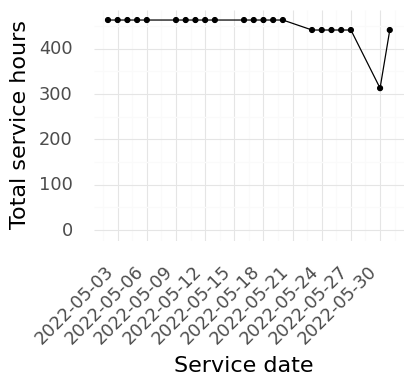

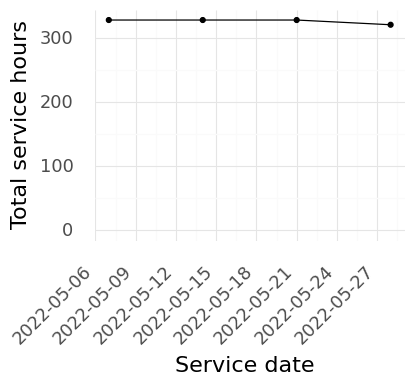

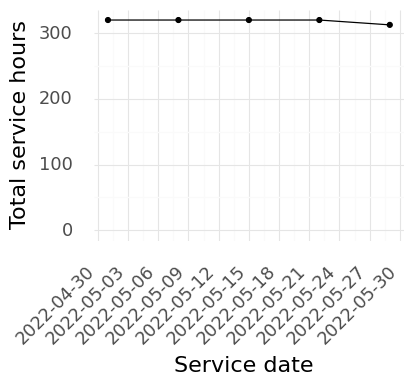

In [34]:
for weekday_range in weekday_ranges:
    p = plot_service_hours(tbl_daily_service, weekday_range[0])
    p.save(out_dir / f"2_service_hours_{weekday_range[1]}.png", width=4, height=3, dpi=300)

In [47]:
## Percent Change Plot

p = (
    pd.concat(
        [
            tbl_stops_changed >> mutate(kind="Stops"),
            tbl_routes_changed >> mutate(kind="Routes"),
        ]
    )
    >> mutate(status = fct_rev(_.status))    
    >> ggplot(aes("kind", "percent", fill="status"))
    + geom_col()
    + scale_fill_manual(limits = CHANGE_PLOT_BREAKS, values = CHANGE_PLOT_VALUES)
    + labs(
        x="GTFS schedule table",
        y="Percentage of IDs",
        #title=f"IDs Changed Between {START_MONTH_DAY} and {END_MONTH_DAY}",
    )
    + scale_y_continuous(labels=percent_format, breaks=np.arange(0, 1.2, 0.2))
    + theme_minimal(base_size=16)
    + theme(legend_position="bottom", legend_margin=30)
)

p.save(out_dir / "3_id_changes.png", width=4, height=4, dpi=300)
# p.draw();